In [18]:
import mne
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Directory paths
edf_dir = r'recordings'  # Replace with the actual path to your EDF files
annotation_dir = r'recordings'  # Replace with the actual path to your annotation files

# Initialize lists to store features and labels
all_wavelet_features = []
all_labels = []

# Define the wavelet transform function
def compute_wavelet_features(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Extract statistics from each wavelet level (mean, std deviation)
    features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    return features

# Iterate over each EDF and annotation file pair
for i in range(10, 99):  # Adjust range if you have more files
    edf_file = os.path.join(edf_dir, f'SN0{i}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN0{i}_sleepscoring.txt')
    
    # Load EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)  # Crop 150s from start and end
    raw.filter(0.5, 30, fir_design='firwin')  # Bandpass filter
    raw.resample(100)  # Resample

    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')
    
    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) &
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150
    
    # Set annotations
    annotations = mne.Annotations(
        onset=filtered_annotations_df['Recording onset'].values,
        duration=filtered_annotations_df['Duration'].values,
        description=filtered_annotations_df['Annotation'].values
    )
    raw.set_annotations(annotations)
    
    # Create events and epochs
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=30, baseline=None, preload=True)
    
    # Encode labels
    labels = epochs.events[:, -1]
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    # Wavelet feature extraction
    eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)
    wavelet_features = []
    for epoch in eeg_data:
        for channel_data in epoch:
            features = compute_wavelet_features(channel_data)
            wavelet_features.append(features)
    wavelet_features = np.array(wavelet_features)
    wavelet_features = wavelet_features.reshape(len(labels), -1)  # Reshape for ML input

    # Append to the main lists
    all_wavelet_features.extend(wavelet_features)
    all_labels.extend(labels)

# Convert lists to arrays for ML
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


Extracting EDF parameters from d:\Clg\Project\sleep stage classification\recordings\SN010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7099647  =      0.000 ... 27732.996 secs...


C:\Users\R MOHANAKRISHNAA\AppData\Local\Temp\ipykernel_55556\4069495122.py:33: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\R MOHANAKRISHNAA\AppData\Local\Temp\ipykernel_55556\4069495122.py:33: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


KeyboardInterrupt: 

In [2]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a simple neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(all_wavelet_features.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # One output per sleep stage
])

# Compile the model
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.25)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
1477/1477 [==============================] - 8s 4ms/step - loss: 1.5315 - accuracy: 0.3669 - val_loss: 1.5276 - val_accuracy: 0.3684
Epoch 2/100
1477/1477 [==============================] - 5s 3ms/step - loss: 1.5270 - accuracy: 0.3672 - val_loss: 1.5265 - val_accuracy: 0.3684
Epoch 3/100
1477/1477 [==============================] - 5s 3ms/step - loss: 1.5260 - accuracy: 0.3672 - val_loss: 1.5264 - val_accuracy: 0.3684
Epoch 4/100
1477/1477 [==============================] - 5s 3ms/step - loss: 1.5260 - accuracy: 0.3672 - val_loss: 1.5262 - val_accuracy: 0.3684
Epoch 5/100
1477/1477 [==============================] - 6s 4ms/step - loss: 1.5255 - accuracy: 0.3672 - val_loss: 1.5262 - val_accuracy: 0.3684
Epoch 6/100
1477/1477 [==============================] - 5s 3ms/step - loss: 1.5251 - accuracy: 0.3672 - val_loss: 1.5261 - val_accuracy: 0.3684
Epoch 7/100
1477/1477 [==============================] - 5s 3ms/step - loss: 1.5250 - accuracy: 0.3672 - val_loss: 1.5264 - val_ac

In [3]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(all_wavelet_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(len(label_encoder.classes_), activation='softmax')  # One output per sleep stage
])

# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.001),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping])

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
1477/1477 [==============================] - 15s 7ms/step - loss: 1.5656 - accuracy: 0.3525 - val_loss: 1.8000 - val_accuracy: 0.1998
Epoch 2/100
1477/1477 [==============================] - 8s 6ms/step - loss: 1.2625 - accuracy: 0.4738 - val_loss: 2.3004 - val_accuracy: 0.2630
Epoch 3/100
1477/1477 [==============================] - 8s 6ms/step - loss: 1.1712 - accuracy: 0.5175 - val_loss: 1.1119 - val_accuracy: 0.5559
Epoch 4/100
1477/1477 [==============================] - 8s 5ms/step - loss: 1.1280 - accuracy: 0.5449 - val_loss: 1.3415 - val_accuracy: 0.4367
Epoch 5/100
1477/1477 [==============================] - 8s 5ms/step - loss: 1.0850 - accuracy: 0.5663 - val_loss: 1.3978 - val_accuracy: 0.3456
Epoch 6/100
1477/1477 [==============================] - 9s 6ms/step - loss: 1.0582 - accuracy: 0.5771 - val_loss: 1.1725 - val_accuracy: 0.5347
Epoch 7/100
1477/1477 [==============================] - 10s 6ms/step - loss: 1.0409 - accuracy: 0.5867 - val_loss: 1.2499 - val_

In [4]:
print("Features shape:", all_wavelet_features.shape)
print("Labels shape:", labels.shape)


Features shape: (78768, 80)
Labels shape: (851,)


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# # Convert to NumPy arrays
# all_wavelet_features = np.array(all_wavelet_features)
# all_labels = np.array(all_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
clf = SVC(kernel='rbf', random_state=42)  # You can choose 'linear', 'poly', 'sigmoid', etc.
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model training completed.
Accuracy: 0.6494858448647962
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.13      0.20      1796
           1       0.58      0.84      0.69      5717
           2       0.77      0.64      0.70      3171
           3       0.72      0.49      0.58      2506
           4       0.73      0.76      0.75      2564

    accuracy                           0.65     15754
   macro avg       0.66      0.57      0.58     15754
weighted avg       0.65      0.65      0.63     15754



In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# # Convert to NumPy arrays
# all_wavelet_features = np.array(all_wavelet_features)
# all_labels = np.array(all_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting classifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model training completed.
Accuracy: 0.4891456138123651
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.10      0.17      1796
           1       0.43      0.90      0.58      5717
           2       0.72      0.31      0.44      3171
           3       0.74      0.17      0.27      2506
           4       0.67      0.37      0.48      2564

    accuracy                           0.49     15754
   macro avg       0.61      0.37      0.39     15754
weighted avg       0.58      0.49      0.44     15754



In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the k-NN classifier
clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model training completed.
Accuracy: 0.7161990605560492
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.38      0.40      1796
           1       0.70      0.80      0.75      5717
           2       0.80      0.81      0.80      3171
           3       0.76      0.69      0.73      2506
           4       0.80      0.67      0.73      2564

    accuracy                           0.72     15754
   macro avg       0.70      0.67      0.68     15754
weighted avg       0.72      0.72      0.71     15754



In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression classifier
clf = LogisticRegression(max_iter=200, random_state=42)  # Increase max_iter if necessary
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Model training completed.
Accuracy: 0.3628919639456646
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1796
           1       0.36      1.00      0.53      5717
           2       0.00      0.00      0.00      3171
           3       0.00      0.00      0.00      2506
           4       0.00      0.00      0.00      2564

    accuracy                           0.36     15754
   macro avg       0.07      0.20      0.11     15754
weighted avg       0.13      0.36      0.19     15754



C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [9]:
! pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.
Accuracy: 0.806398375015869
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.44      0.50      1796
           1       0.78      0.86      0.82      5717
           2       0.88      0.83      0.85      3171
           3       0.87      0.83      0.85      2506
           4       0.83      0.89      0.86      2564

    accuracy                           0.81     15754
   macro avg       0.79      0.77      0.78     15754
weighted avg       0.80      0.81      0.80     15754



C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.
Accuracy: 0.806398375015869
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.44      0.50      1796
           1       0.78      0.86      0.82      5717
           2       0.88      0.83      0.85      3171
           3       0.87      0.83      0.85      2506
           4       0.83      0.89      0.86      2564

    accuracy                           0.81     15754
   macro avg       0.79      0.77      0.78     15754
weighted avg       0.80      0.81      0.80     15754



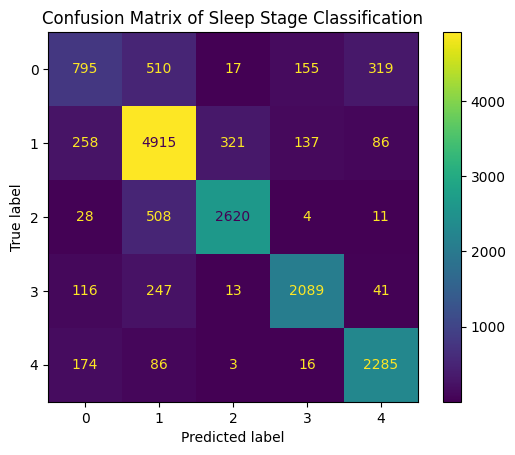

C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Scores: [0.68192205 0.63444205 0.62079472 0.58293658 0.70830953]
Average CV Score: 0.645680985732028


In [10]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert to NumPy arrays
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.
Accuracy: 0.8067027758970887
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.45      0.51      1397
           1       0.78      0.86      0.82      4287
           2       0.88      0.82      0.85      2314
           3       0.87      0.85      0.86      1911
           4       0.83      0.89      0.86      1907

    accuracy                           0.81     11816
   macro avg       0.79      0.77      0.78     11816
weighted avg       0.80      0.81      0.80     11816



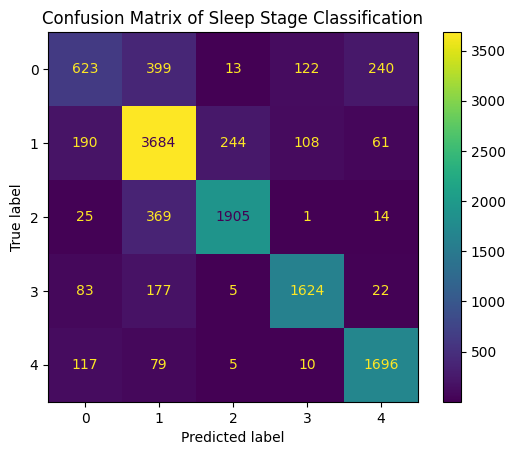

C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\R MOHANAKRISHNAA\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Cross-Validation Scores: [0.68192205 0.63444205 0.62079472 0.58293658 0.70830953]
Average CV Score: 0.645680985732028


In [11]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert to NumPy arrays
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.15, random_state=32)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


In [12]:
# import numpy as np
# import xgboost as xgb
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Convert to NumPy arrays
# all_wavelet_features = np.array(all_wavelet_features)
# all_labels = np.array(all_labels)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.15, random_state=32)

# # Set up the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# # Initialize the XGBoost classifier
# clf = xgb.XGBClassifier(use_label_encoder=False, random_state=42)

# # Perform Grid Search
# grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)

# # Use the best model found
# best_clf = grid_search.best_estimator_

# # Train the best model
# best_clf.fit(X_train, y_train)

# # Make predictions
# y_pred = best_clf.predict(X_test)

# # Display accuracy and classification report
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

# # Display the confusion matrix
# disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
# plt.title("Confusion Matrix of Sleep Stage Classification")
# plt.show()

# # 5-fold cross-validation on the best model
# cv_scores = cross_val_score(best_clf, all_wavelet_features, all_labels, cv=5)
# print("Cross-Validation Scores:", cv_scores)
# print("Average CV Score:", np.mean(cv_scores))


SVM model training completed.
SVM Test Accuracy: 0.6549593771157752
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.11      0.18      1397
           1       0.58      0.86      0.70      4287
           2       0.78      0.64      0.70      2314
           3       0.74      0.50      0.60      1911
           4       0.74      0.76      0.75      1907

    accuracy                           0.65     11816
   macro avg       0.66      0.58      0.59     11816
weighted avg       0.66      0.65      0.63     11816



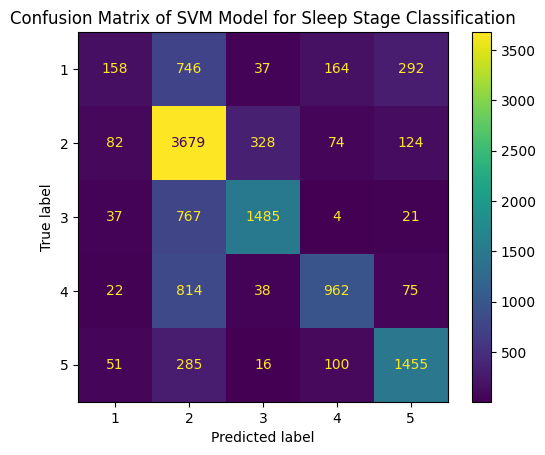

SVM Cross-Validation Scores: [0.64423867 0.64871929 0.64115011 0.64047797 0.6540702 ]
Average CV Score: 0.6457312478273811


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Initialize the SVM classifier with a radial basis function (RBF) kernel
svm_clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Train the SVM model
svm_clf.fit(X_train, y_train)
print("SVM model training completed.")

# Make predictions on the test set
y_pred = svm_clf.predict(X_test)

# Display accuracy and classification report
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of SVM Model for Sleep Stage Classification")
plt.show()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
print("SVM Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


In [15]:
!pip install niapy


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 985.5 kB/s eta 0:00:08
   -- ------------------------------------- 0.5/7.8 MB 985.5 kB/s eta 0:00:08
   ---- ----------------------------------- 0.8/7.8 MB 632.4 kB/s eta 0:00:12
   ------ --------------------------------- 1.3/7.8 MB 1.0 MB/s eta 0:00:07
   -------- ------------------------------- 1.6/7.8 MB 1.0 MB/s eta 0:00:07
   --------- ------------------------------ 1.8/7.8 MB 1.1 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/7.8 MB 1.1 MB/s eta 0:00:06
   -------------- ------------------------- 2.9/7.8 MB 1.4 MB/s eta 0:00:04
   ----------------- ---------------------- 3.4/7.8 MB 1.5 MB/s eta 0:00:03
   -------------------- -

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\r mohanakrishnaa\\appdata\\roaming\\python\\python311\\site-packages\\matplotlib\\backends\\_backend_agg.cp311-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from niapy.task import Task
from niapy.problems import Problem
from niapy.algorithms.basic import FireflyAlgorithm

# Split data
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.15, random_state=32)

# Define a custom problem for optimizing XGBoost with Firefly Algorithm
class XGBoostHyperparameterOptimization(Problem):
    def __init__(self):
        super().__init__(dimension=5, lower=[50, 3, 0.01, 0.6, 0], upper=[150, 7, 0.3, 1.0, 0.5])

    def _evaluate(self, solution):
        # Extract parameters from the solution array
        n_estimators = int(solution[0])
        max_depth = int(solution[1])
        learning_rate = solution[2]
        subsample = solution[3]
        gamma = solution[4]

        # Initialize the XGBoost classifier with the current parameters
        xgb_clf = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            gamma=gamma,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )

        # Perform cross-validation and return the negative mean accuracy (minimize)
        cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy')
        return -np.mean(cv_scores)  # Use negative because FireflyAlgorithm minimizes the objective

# Set up the optimization task
task = Task(problem=XGBoostHyperparameterOptimization(), max_iters=50)

# Initialize the Firefly Algorithm
algo = FireflyAlgorithm(population_size=20, alpha=0.5, beta_min=0.2, gamma=1.0)

# Run the optimization
best_solution, best_score = algo.run(task)
print(f"Best CV Score (optimized): {-best_score}")  # Make positive again
print("Best parameters found by Firefly Algorithm:", best_solution)

# Extract optimized parameters
n_estimators = int(best_solution[0])
max_depth = int(best_solution[1])
learning_rate = best_solution[2]
subsample = best_solution[3]
gamma = best_solution[4]

# Train final model with optimized parameters
best_xgb_clf = xgb.XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    subsample=subsample,
    gamma=gamma,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
best_xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_clf.predict(X_test)

# Display accuracy and classification report
print("XGBoost Test Accuracy with Optimized Parameters:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
plt.title("Confusion Matrix of Optimized XGBoost Model for Sleep Stage Classification")
plt.show()


ModuleNotFoundError: No module named 'niapy'

In [ ]:
# ! pip install deap
# import numpy as np
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from deap import base, creator, tools, algorithms

# # Assuming all_wavelet_features and all_labels have been prepared
# all_wavelet_features = np.array(all_wavelet_features)
# all_labels = np.array(all_labels)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# # Define the fitness function
# def evaluate_individual(individual):
#     # Assign C and gamma from the individual
#     C = individual[0]
#     gamma = individual[1]
#     # Create and evaluate an SVM with these hyperparameters
#     clf = SVC(C=C, gamma=gamma, kernel='rbf', random_state=42)
#     scores = cross_val_score(clf, X_train, y_train, cv=5)
#     return np.mean(scores),

# # Set up the DEAP genetic algorithm framework
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
# creator.create("Individual", list, fitness=creator.FitnessMax)

# toolbox = base.Toolbox()
# toolbox.register("attr_float", np.random.uniform, 0.01, 1000)  # Range for C and gamma
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# # Register the evaluation, mutation, crossover, and selection functions
# toolbox.register("evaluate", evaluate_individual)
# toolbox.register("mate", tools.cxBlend, alpha=0.5)
# toolbox.register("mutate", tools.mutPolynomialBounded, low=0.01, up=1000, eta=0.5, indpb=0.2)
# toolbox.register("select", tools.selTournament, tournsize=3)

# # Initialize the population
# population = toolbox.population(n=20)
# n_generations = 10

# # Run the genetic algorithm
# for generation in range(n_generations):
#     offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
#     fits = map(toolbox.evaluate, offspring)
    
#     for fit, ind in zip(fits, offspring):
#         ind.fitness.values = fit
    
#     population = toolbox.select(offspring, k=len(population))
#     top_individual = tools.selBest(population, k=1)[0]
#     print(f"Generation {generation + 1} | Best C: {top_individual[0]}, Best gamma: {top_individual[1]}, Best Score: {top_individual.fitness.values[0]}")

# # Get the best parameters from the genetic algorithm
# best_C, best_gamma = top_individual[0], top_individual[1]
# print(f"Optimized C: {best_C}, Optimized gamma: {best_gamma}")

# # Train the final SVM model with the optimized parameters
# clf = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=42)
# clf.fit(X_train, y_train)

# # Make predictions
# y_pred = clf.predict(X_test)

# # Display accuracy and classification report
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

# # Display the confusion matrix
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
# plt.title("Confusion Matrix of Optimized SVM with Genetic Algorithm")
# plt.show()

In [ ]:
# # !pip install deap xgboost
# import numpy as np
# import xgboost as xgb
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from deap import base, creator, tools, algorithms

# # Assuming all_wavelet_features and all_labels have been prepared
# all_wavelet_features = np.array(all_wavelet_features)
# all_labels = np.array(all_labels)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# # Define the fitness function
# def evaluate_individual(individual):
#     # Assign hyperparameters from the individual
#     n_estimators = int(individual[0])
#     max_depth = int(individual[1])
#     learning_rate = individual[2]
#     subsample = individual[3]
    
#     # Create and evaluate an XGBoost classifier with these hyperparameters
#     clf = xgb.XGBClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         use_label_encoder=False,
#         eval_metric='mlogloss',
#         random_state=42
#     )
#     scores = cross_val_score(clf, X_train, y_train, cv=3)  # Use 3-fold cross-validation
#     return np.mean(scores),

# # Set up the DEAP genetic algorithm framework
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
# creator.create("Individual", list, fitness=creator.FitnessMax)

# toolbox = base.Toolbox()
# toolbox.register("attr_int", np.random.randint, 50, 300)   # Range for n_estimators
# toolbox.register("attr_int_max_depth", np.random.randint, 3, 15)   # Range for max_depth
# toolbox.register("attr_float_lr", np.random.uniform, 0.01, 0.3)  # Range for learning_rate
# toolbox.register("attr_float_subsample", np.random.uniform, 0.5, 1.0)  # Range for subsample
# toolbox.register("individual", tools.initCycle, creator.Individual, 
#                  (toolbox.attr_int, toolbox.attr_int_max_depth, toolbox.attr_float_lr, toolbox.attr_float_subsample), n=1)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# # Register the evaluation, mutation, crossover, and selection functions
# toolbox.register("evaluate", evaluate_individual)
# toolbox.register("mate", tools.cxBlend, alpha=0.5)
# toolbox.register("mutate", tools.mutPolynomialBounded, low=[50, 3, 0.01, 0.5], up=[300, 15, 0.3, 1.0], eta=0.1, indpb=0.2)
# toolbox.register("select", tools.selTournament, tournsize=3)

# # Initialize the population
# population = toolbox.population(n=20)
# n_generations = 10

# # Run the genetic algorithm
# for generation in range(n_generations):
#     offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
#     fits = map(toolbox.evaluate, offspring)
    
#     for fit, ind in zip(fits, offspring):
#         ind.fitness.values = fit
    
#     population = toolbox.select(offspring, k=len(population))
#     top_individual = tools.selBest(population, k=1)[0]
#     print(f"Generation {generation + 1} | Best n_estimators: {top_individual[0]}, max_depth: {top_individual[1]}, learning_rate: {top_individual[2]}, subsample: {top_individual[3]}, Best Score: {top_individual.fitness.values[0]}")

# # Get the best parameters from the genetic algorithm
# best_n_estimators = int(top_individual[0])
# best_max_depth = int(top_individual[1])
# best_learning_rate = top_individual[2]
# best_subsample = top_individual[3]
# print(f"Optimized n_estimators: {best_n_estimators}, max_depth: {best_max_depth}, learning_rate: {best_learning_rate}, subsample: {best_subsample}")

# # Train the final XGBoost model with the optimized parameters
# clf = xgb.XGBClassifier(
#     n_estimators=best_n_estimators,
#     max_depth=best_max_depth,
#     learning_rate=best_learning_rate,
#     subsample=best_subsample,
#     use_label_encoder=False,
#     eval_metric='mlogloss',
#     random_state=42
# )
# clf.fit(X_train, y_train)

# # Make predictions
# y_pred = clf.predict(X_test)

# # Display accuracy and classification report
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

# # Display the confusion matrix
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
# plt.title("Confusion Matrix of Optimized XGBoost with Genetic Algorithm")
# plt.show()